In [102]:
import csv
import pandas as pd
import numpy as np
import datetime
import matplotlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
  

import csv
import operator

from sklearn import preprocessing

from sklearn.metrics import roc_auc_score

# Files

In [103]:
train_file_name = "train_dK8Auve.csv"
test_file_name = "test_UyrvqPb.csv"

# Count variables

In [104]:
def getCountVar(compute_df, count_df, var_name, count_var="Manager_Num_Application"):
        grouped_df = count_df.groupby(var_name, as_index=False)[count_var].agg('count')
        grouped_df.columns = [var_name, "var_count"]
        merged_df = pd.merge(compute_df, grouped_df, how="left", on=var_name)
        merged_df.fillna(-1, inplace=True)
        return list(merged_df["var_count"])

# Main Function

In [111]:


if __name__ == "__main__":
    print("Reading files..")
    train = pd.read_csv(train_file_name)
    test = pd.read_csv(test_file_name)
    print(train.shape, test.shape)

    print("Rank vars..")
    prev_date = 0
    count_dict = {}
    for name, row in train.iterrows():
            count_dict[ row["Application_Receipt_Date"] ] = count_dict.get(row["Application_Receipt_Date"],0) + 1
    for name, row in test.iterrows():
            count_dict[ row["Application_Receipt_Date"] ] = count_dict.get(row["Application_Receipt_Date"],0) + 1

    prev_date = 0
    rank_list = []
    count_list = []
    rankpct_list = []
    for name, row in train.iterrows():
            date_value = row["Application_Receipt_Date"]
            if date_value != prev_date:
                    rank = 1
                    prev_date = date_value
            else:
                    rank += 1
            rank_list.append( rank )
            count_list.append( count_dict[date_value] )
            rankpct_list.append( float(rank) / count_dict[date_value] )
    train["dayrank"] = rank_list[:]
    train["daycount"] = count_list[:]
    train["dayrankpct"] = rankpct_list[:]

    prev_date = 0
    rank_list = []
    count_list = []
    rankpct_list = []
    for name, row in test.iterrows():
            date_value = row["Application_Receipt_Date"]
            if date_value != prev_date:
                    rank = 1
                    prev_date = date_value
            else:
                    rank += 1
            rank_list.append( rank )
            count_list.append( count_dict[date_value] )
            rankpct_list.append( float(rank) / count_dict[date_value] )
    test["dayrank"] = rank_list[:]
    test["daycount"] = count_list[:]
    test["dayrankpct"] = rankpct_list[:]
    print(train.dayrank.describe())
    print(test.dayrank.describe())

    print("Getting DV and ID..")
    train_y = train.Business_Sourced.values
    train_ID = train.ID.values
    test_ID = test.ID.values

    print("New feats..")
    print("Some more features..")
    new_feats = ["DOJ_DOB", "DOB_Applicant_Gender", "DOB_Qualification", "DOB_Gender_Qual"] 
    train["DOJ_DOB"] = train["Manager_DOJ"].astype('str') + "_" + train["Manager_DoB"].astype('str')
    train["DOB_Applicant_Gender"] = train["Manager_DoB"].astype('str') + "_" + train["Applicant_Gender"].astype('str')
    train["DOB_Qualification"] = train["Manager_DoB"].astype('str') + "_" + train["Applicant_Qualification"].astype('str')
    train["DOB_Gender_Qual"] = train["Manager_DoB"].astype('str') + "_" + train["Applicant_Gender"].astype('str') + "_" + train["Applicant_Qualification"].astype('str')
    test["DOJ_DOB"] = test["Manager_DOJ"].astype('str') + "_" + test["Manager_DoB"].astype('str')
    test["DOB_Applicant_Gender"] = test["Manager_DoB"].astype('str') + "_" + test["Applicant_Gender"].astype('str')
    test["DOB_Qualification"] = test["Manager_DoB"].astype('str') + "_" + test["Applicant_Qualification"].astype('str')
    test["DOB_Gender_Qual"] = test["Manager_DoB"].astype('str') + "_" + test["Applicant_Gender"].astype('str') + "_" + test["Applicant_Qualification"].astype('str')

    print("Label encoding..")
    cat_columns = ["Applicant_Gender", "Applicant_Marital_Status", "Applicant_Occupation", "Applicant_Qualification", "Manager_Joining_Designation", "Manager_Current_Designation", "Manager_Status", "Manager_Gender"]
    for f in cat_columns + new_feats:
                        #print((f), len(np.unique(train[f].values)))
                        lbl = preprocessing.LabelEncoder()
                        lbl.fit(list(train[f].values) + list(test[f].values))
                        train[f] = lbl.transform(list(train[f].values))
                        test[f] = lbl.transform(list(test[f].values))
                        new_train = pd.concat([ train[['Manager_Num_Application',f]], test[['Manager_Num_Application',f]] ])
                        train["CountVar_"+str(f)] = getCountVar(train[['Manager_Num_Application',f]], new_train[['Manager_Num_Application', f]], f)
                        test["CountVar_"+str(f)] = getCountVar(test[['Manager_Num_Application',f]], new_train[['Manager_Num_Application',f]], f)

    print("Working on dates..")
    for date_col in ["Application_Receipt_Date", "Applicant_BirthDate", "Manager_DOJ", "Manager_DoB"]:
        print(date_col)
        train[date_col].fillna("1/1/1900", inplace=True)
        test[date_col].fillna("1/1/1900", inplace=True)
        train[date_col] = (pd.to_datetime(train[date_col], format="%m/%d/%Y"))
        test[date_col] = (pd.to_datetime(test[date_col], format="%m/%d/%Y"))
        train[date_col] = train[date_col].apply(lambda x: x.toordinal())
        test[date_col] = test[date_col].apply(lambda x: x.toordinal())

    dev_index = np.where(train["Application_Receipt_Date"]<=733100)[0]
    val_index = np.where(train["Application_Receipt_Date"]>733100)[0]
    print("Dropping unwanted cols..")
    drop_cols = []
    train.drop(["ID", "Business_Sourced"]+drop_cols, axis=1, inplace=True)
    test.drop(["ID"] + drop_cols, axis=1, inplace=True)

    print("Fill NA..")
    train.fillna(-999, inplace=True)
    test.fillna(-999, inplace=True)

    print("New features..")
    train["Manager_Business2"] = train["Manager_Business"] - train["Manager_Business2"]
    test["Manager_Business2"] = test["Manager_Business"] - test["Manager_Business2"]
    train["Manager_Num_Products2"] = train["Manager_Num_Products"] - train["Manager_Num_Products2"]
    test["Manager_Num_Products2"] = test["Manager_Num_Products"] - test["Manager_Num_Products2"]

    print("Converting to array..")
    feat_names = list(train.columns)
    train = np.array(train)
    test = np.array(test)
    print(train.shape, test.shape)
    assert train.shape[1] == test.shape[1]


    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.3, random_state=0)
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression(solver='liblinear',class_weight='balanced',max_iter=300)
    log=logreg.fit(X_train, y_train)
    y_pred = log.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    # full_preds = 0
    # for rs in [1, 1343, 445234]:
    #         preds = runXGB(train, train_y, test, feature_names=feat_names, seed_val = rs)
    #         full_preds += preds
    # full_preds /= 3.




Reading files..
(9527, 23) (5045, 22)
Rank vars..
count    9527.000000
mean       20.108849
std        18.614587
min         1.000000
25%         7.000000
50%        15.000000
75%        27.000000
max       165.000000
Name: dayrank, dtype: float64
count    5045.000000
mean       35.843608
std        42.023915
min         1.000000
25%        10.000000
50%        22.000000
75%        44.000000
max       273.000000
Name: dayrank, dtype: float64
Getting DV and ID..
New feats..
Some more features..
Label encoding..
Working on dates..
Application_Receipt_Date
Applicant_BirthDate
Manager_DOJ
Manager_DoB
Dropping unwanted cols..
Fill NA..
New features..
Converting to array..
(9527, 40) (5045, 40)
Accuracy of logistic regression classifier on test set: 0.80


# ROC SCORE

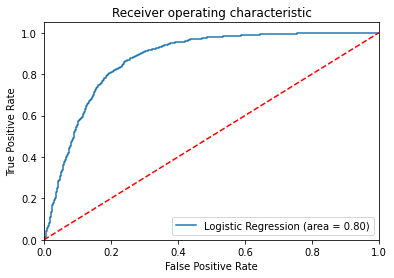

In [112]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test),average='weighted')
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [98]:
from sklearn import svm
clf = svm.SVC(probability=True,class_weight='balanced')
clf.fit(X_train , y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = clf.predict(X_test)

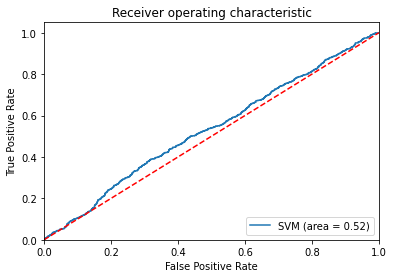

In [99]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()

In [101]:
y_preds = log.predict(test)
out_df = pd.DataFrame({"ID":test_ID})
out_df["Business_Sourced"] = y_preds
out_df.to_csv("final.csv", index=False)